# Exercises on PCA

## Exercise 3: Outlier detection

The goal of the exercise is to use PCA to detect the outlier on a toy dataset.
The toy dataset is a matrix that contains 2 features ($x$ and $y$) and 100 samples. 
For the first 95 samples, $x$ is in the range $[0, 10]$ and $y = 4x + 2 + \epsilon$, where $\epsilon$ is Gaussian noise with $\mu = 0 $ and $\sigma = 2.5$. The last 5 points are outliers with $x_{\mathrm{out}}$ is in the range $[2, 3]$ and $y_{\mathrm{out}} = 3 x^2 + x + 10 + \epsilon_{\mathrm{out}}$, where $\epsilon_{\mathrm{out}}$ is Gaussian noise with $\mu_{\mathrm{out}} = 0 $ and $\sigma_{\mathrm{out}} = 5$

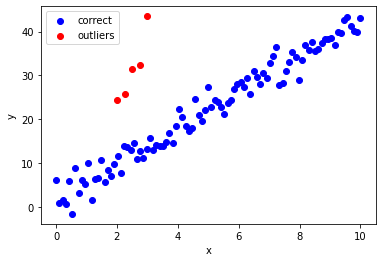

In [30]:
# First we import the libraries 
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk

n_points = 95 # number of points in the dataset
x = np.linspace(0, 10, n_points) # the function linspace creates a vector of 95 values in the range [0,10]

# this command is used to set a fixed seed for random sampling, 
# so that we have the same result when re-running the code.
np.random.seed(1) 

noise = np.random.normal(0, 2.5, size=n_points) # a vector of noise 
y = 4*x + 2 + noise

n_outl = 5
x_outl = np.linspace(2, 3, n_outl)
noise_outl = np.random.normal(0, 5, size=n_outl)
y_outl = 3*x_outl**2 + x_outl + 10 + noise_outl

fig, ax = plt.subplots(figsize=(6,4))
ax.scatter(x, y, c='b', label='correct')
ax.scatter(x_outl, y_outl, c='r', label='outliers')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.legend()
plt.show()

Now that we have computed the correct values and the outliers, we have to put them in a single dataset, so that we simulate a dataset that has been corrupted with outliers.

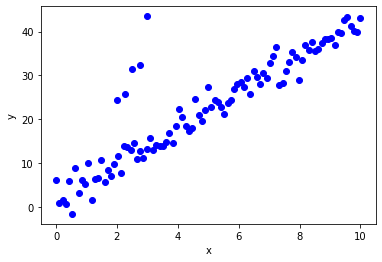

In [32]:
D = np.empty((n_points + n_outl, 2)) # create an empty matrix of size (n_points + n_outl, 2)

# the function concatenate is used to (you guessed it) concatenate the x and y arrays and
# store them in the D matrix
D[:,0] = np.concatenate([x, x_outl]) 
D[:,1] = np.concatenate([y, y_outl])

fig, ax = plt.subplots(figsize=(6,4))
ax.scatter(D[:,0], D[:,1], c='b')
ax.set_xlabel('x')
ax.set_ylabel('y')
plt.show()

Now we need to perform PCA on the data matrix, and we use the implementation on the scikit-learn library.
Before doing PCA, we center and scale the matrix (you can try and see what happens if you don't do it).

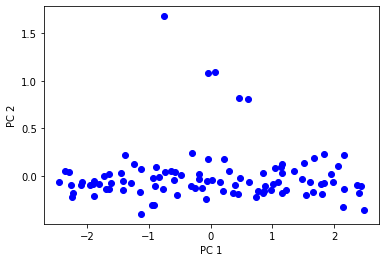

In [59]:
from sklearn.decomposition import PCA

# Center and scale the matrix
D0 = (D - np.mean(D, axis=0))/np.std(D, axis=0)

# Perform PCA
pca = PCA()
pca.fit(D0)

# Compute the PCs and the scores
A = pca.components_.T
Z = D0 @ A
lamda = pca.singular_values_**2 #the eigenvectors are the singular values squared

# Plot the scores
fig, ax = plt.subplots(figsize=(6,4))
ax.scatter(Z[:,0], Z[:,1], c='b')
ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')
plt.show()

To find the outliers, we build a classifier using the 2nd PC. To do that, we compute the empirical cumulative distribution function (ecdf) of PC scores squared divided by the corresponding eigenvalue (Mahalanobis distance):

\begin{equation}
d_{M, i} = \frac{z^2_{i,2}}{l_2}
\end{equation}

\begin{equation}
\mathrm{edfc}(t) = \sum_{j = 1}^k d_{M, j} < t
\end{equation}

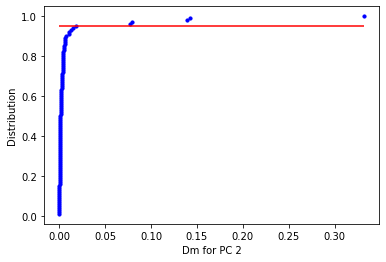

In [83]:
def ecdf(pc):
    i_sort = np.argsort(pc)
    pc_sort = pc[i_sort]
    dist_sort = np.arange(1, pc_sort.size+1)/pc_sort.size
    return i_sort, pc_sort, dist_sort

# We calculate the Mahalanobis distance using PC2
dm_pc2 = Z[:,1]**2/lamda[1]
i_sort, pc2_sort, dist_sort = ecdf(dm_pc2)
threshold = 0.95

# We plot the cumulative distribution
fig, ax = plt.subplots(figsize=(6,4))
ax.scatter(pc2_sort, dist_sort, c='b', s=10)
ax.set_xlabel('Dm for PC 2')
ax.set_ylabel('Distribution')
ax.hlines(threshold, pc2_sort.min(), pc2_sort.max(), color='r')
plt.show()

From the cumulative distribution, we can define the points above a certain threshold as outliers.

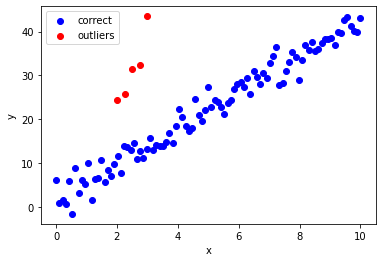

In [85]:
mask = dist_sort > threshold  # this mask operation creates a boolean array that follows the conditions we impose

fig, ax = plt.subplots(figsize=(6,4))
ax.scatter(D[i_sort[~mask], 0], D[i_sort[~mask], 1], c='b', label='correct')
ax.scatter(D[i_sort[mask], 0], D[i_sort[mask], 1], c='r', label='outliers')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.legend()
plt.show()